<a href="https://colab.research.google.com/github/trevorwjames/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Trevor_James_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [64]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [65]:
import pandas as pd
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
  # creating copy
  X = X.copy()

  # conver date to datetime format
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  # extract components of datetime
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')


  # Engineered feature - # of years from construction to date recorded
  X['year'] = X['year_recorded'] - X['construction_year']

  # drop columns that do not vary
  unusable_variance = ['recorded_by', 'id']
  X = X.drop(columns=unusable_variance)

  # duplicate columns that can create repitition
  duplicate_columns = ['waterpoint_type_group', 'payment_type', 
                      'extraction_type_group']
  X = X.drop(columns=duplicate_columns)

  # Treating the very small near 0 features like Nan or zeros
  X['latitude'] = X['latitude'].replace(-2e-08, np.nan)

  # columns that have zeros that really should be NaNs
  cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
  for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

  return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

target = 'status_group'
train, val = train_test_split(train, test_size=len(test), stratify=train[target], random_state=42)

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [66]:
X_train['date_recorded'] = pd.to_datetime(X_train['date_recorded'], infer_datetime_format=True)

In [67]:
X_train['date_recorded'].head()

45793   2011-03-30
26326   2011-02-28
53251   2013-01-27
26791   2011-02-27
2162    2013-01-18
Name: date_recorded, dtype: datetime64[ns]

In [68]:
pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(max_depth=19, min_samples_split=4, max_features='sqrt')
)

pipeline

Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function wrangle at 0x7fef2e8edf28>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=None, drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=None, return_df=Tru...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=19, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                         

In [69]:
# fit pipeline on data

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Val Accuracy:', accuracy_score(y_val, y_pred))

Val Accuracy: 0.8100710405348934


# Confusion Matrix

In [70]:
from sklearn.metrics import precision_score, recall_score

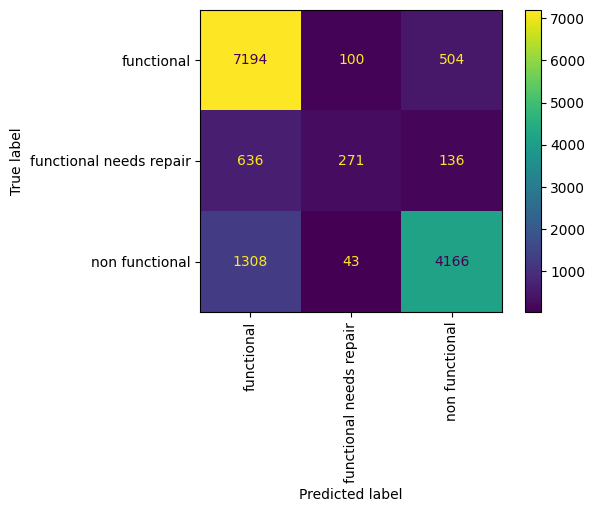

In [71]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [72]:
print('accuracy score:', accuracy_score(y_val, y_pred))
print(precision_score(y_val, y_pred, average=None))
print(recall_score(y_val, y_pred, average=None))

accuracy score: 0.8100710405348934
[0.78726198 0.65458937 0.86683313]
[0.92254424 0.25982742 0.75512054]


In [73]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      7798
functional needs repair       0.65      0.26      0.37      1043
         non functional       0.87      0.76      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.77      0.65      0.68     14358
           weighted avg       0.81      0.81      0.80     14358



# Submission To Kaggel on todays model

In [74]:
# training model on more data = More Betta! 
X_train2 = pd.concat([X_train, X_val])
y_train2 = pd.concat([y_train, y_val])

In [75]:
# fitting model to new bigger data, making sure nothing went wrong
pipeline.fit(X_train2, y_train2)

print('Training Data Accuracy:', pipeline.score(X_train, y_train))
print('Val data accuracy:', pipeline.score(X_val, y_val))

Training Data Accuracy: 0.9153900803694329
Val data accuracy: 0.9198356317035798


In [76]:
# Submission cell
y_pred = pipeline.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('trevor-james-submission9.csv', index=False)